# Módulo 4 - Projeto 1: *support vector machines*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitora: Alana Santana -- alana.correia@ic.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/610](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=610)

Instituto de Computação - Unicamp 2024

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

In [2]:
np.random.seed(1082141)
# sns.set()

## Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [3]:
x, y = datasets.load_digits(return_X_y=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')
# 8*8 = 64: Cada linha representa um pixel da imagem

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 64 primeiras amostras no conjunto de treinamento

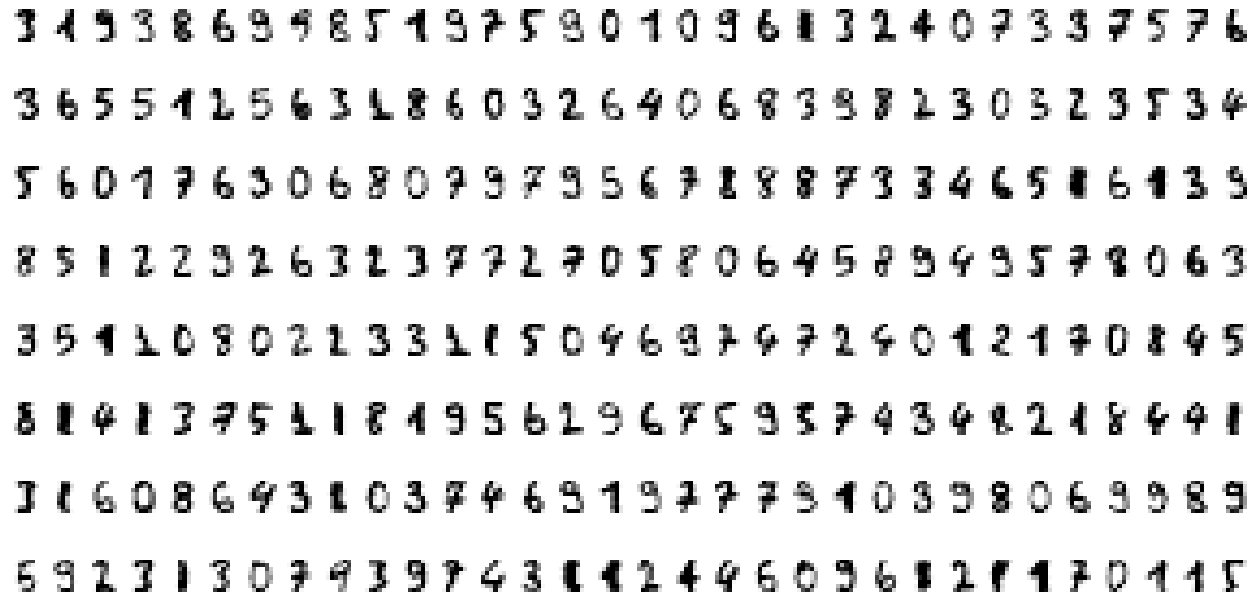

In [5]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

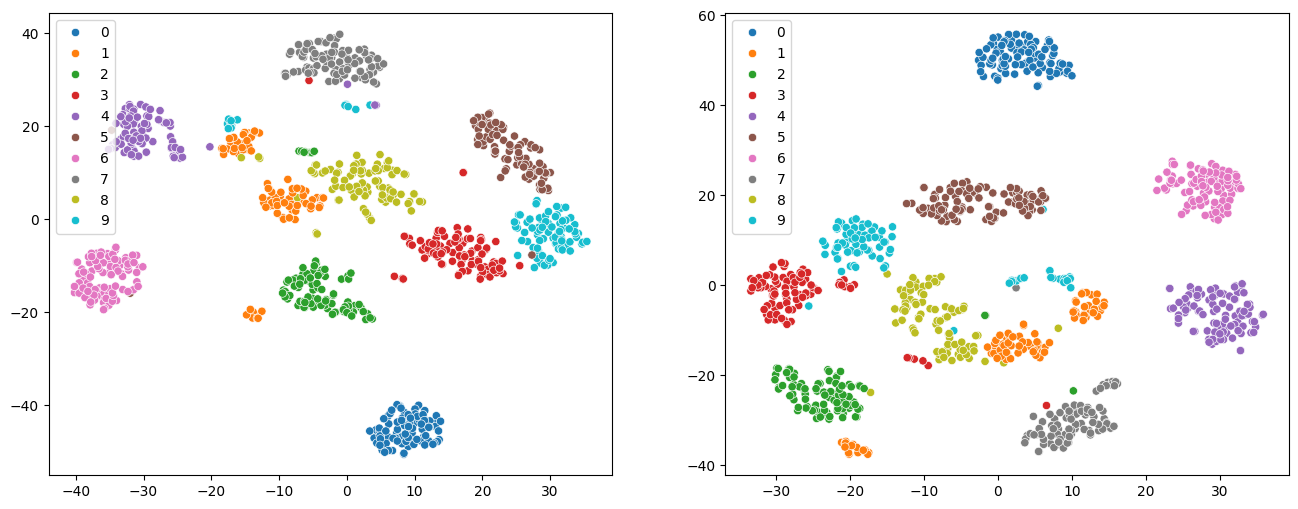

In [6]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate( ( (w_train, y_train), (w_test, y_test) ) ):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, palette=categorical_colors);

<Axes: title={'center': 'Frequencia das classes no conjunto de teste (899 amostras)'}>

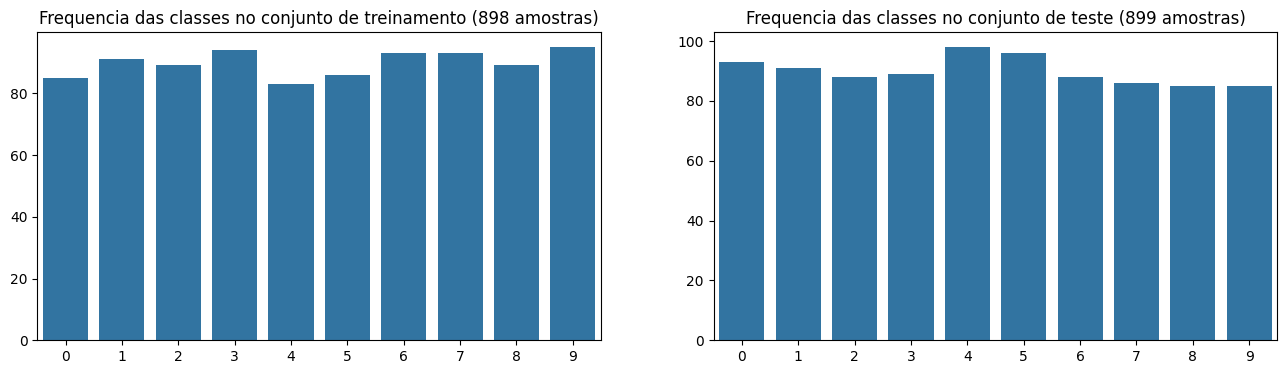

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=labels, y=counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=labels, y=counts)

### Modelando um classificador de digitos

**Atividade (3 pts):** defina e treine uma máquina de vetor de suporte com diferentes tipos de kernel, utilizando o scikit-learn. Avalie os diversos tipos de kernel e seus respectivos parâmetros com relação a qualidade da solução. Você deve separar uma parte do conjunto de treino para fazer a validação cruzada. Não utilize o conjunto de teste ainda.

In [8]:
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn import svm

from sklearn.model_selection import KFold

In [10]:
# Preparing the datasets
full_train_df = pd.DataFrame(x_train)
full_train_df["y"] = y_train

test_df = pd.DataFrame(x_test)
test_df["y"] = y_test

In [11]:
full_train_df.shape, test_df.shape

((898, 65), (899, 65))

In [17]:
def prepare_data(df):

    x = df.loc[:, range(0, 64)].values
    y = df["y"].values

    return x, y

def predict(x, model):
    
    y_pred = model.predict(x)
    
    return y_pred

In [14]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

penalties = np.logspace(-6, 4, 10)
kernel_dict = {}

for k in ["linear", "poly", "rbf", "sigmoid"]:
    print(f"kernel: {k}")
    accs_train, accs_val = [], []
    for C in penalties:
        scores_train = []
        scores_val = []

        for train_idx, val_idx in tqdm(kfold.split(full_train_df)):
            
            # Prepare the training and validation data
            train_df = full_train_df.iloc[train_idx]
            val_df = full_train_df.iloc[val_idx]

            scaler = MinMaxScaler()
            train_df.loc[:, range(0, 64)] = scaler.fit_transform(train_df.loc[:, range(0, 64)])
            val_df.loc[:, range(0, 64)] = scaler.transform(val_df.loc[:, range(0, 64)])
            
            xtrain, ytrain = prepare_data(train_df)
            xval, yval = prepare_data(val_df)

            # Train the model
            model = svm.SVC(kernel=k, C=C)
            model.fit(xtrain, ytrain)

            # Make predictions
            y_train_pred = predict(xtrain, model)
            y_val_pred = predict(xval, model)
            
            acc_train = accuracy_score(ytrain, y_train_pred)
            acc_val = accuracy_score(yval, y_val_pred)
            
            scores_train.append(acc_train)
            scores_val.append(acc_val)

        accs_train.append(np.mean(scores_train))
        accs_val.append(np.mean(scores_val))
    
    kernel_dict[k] = (accs_train, accs_val)

kernel: linear


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

kernel: poly


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

kernel: rbf


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

kernel: sigmoid


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

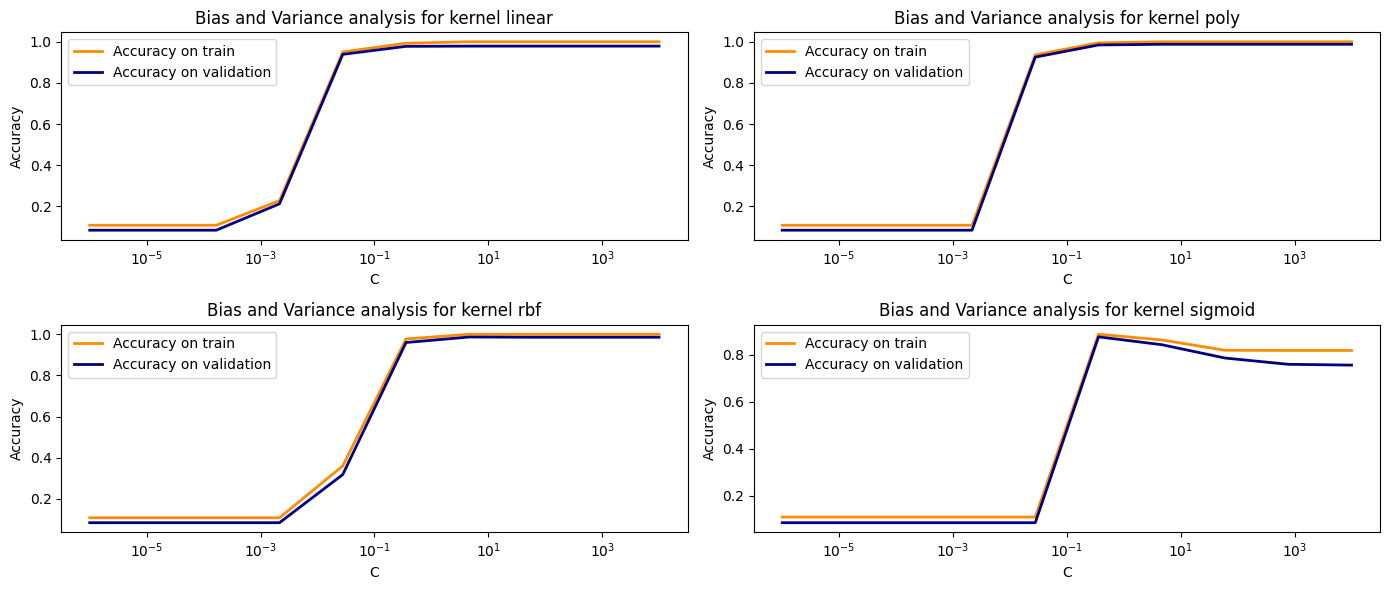

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the array of axes

for i, k in enumerate(["linear", "poly", "rbf", "sigmoid"]):
    accTrain = kernel_dict[k][0]
    accVal = kernel_dict[k][1]
    xs = penalties

    axs[i].semilogx(xs, accTrain, label="Accuracy on train",
                    color="darkorange", lw=2)
    axs[i].semilogx(xs, accVal, label="Accuracy on validation",
                    color="navy", lw=2)

    axs[i].set_xlabel("C")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_title(f"Bias and Variance analysis for kernel {k}")
    axs[i].legend()

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


In [16]:
# The best model is the one with the best accuracy on validation
for k in ["linear", "poly", "rbf", "sigmoid"]:

    best_val_idx = np.argmax( kernel_dict[k][1] )

    print(k, ":", kernel_dict[k][1][best_val_idx], ",", penalties[best_val_idx])

linear : 0.9788454376163873 , 4.641588833612782
poly : 0.9877653631284916 , 4.641588833612782
rbf : 0.9866480446927375 , 4.641588833612782
sigmoid : 0.8764121663563005 , 0.3593813663804626


### Avaliando o modelo treinado

**Atividade (2 pts):** avalie o seu melhor modelo treinado no item anterior sobre o conjunto de teste previamente separado. Reporte a acurácia média, a matriz de confusão e outras métricas que achar válido.

In [18]:
# Analysing all the kernels, the best one was the poly kernel with
# accuracy = 0.9877653631284916 and C = 4.641588833612782

# Training the best model on the full train dataset
norm_full_train_df = full_train_df.copy()
norm_test_df = test_df.copy()

scaler = MinMaxScaler()
norm_full_train_df.loc[:, range(0, 64)] = scaler.fit_transform(norm_full_train_df.loc[:, range(0, 64)])
norm_test_df.loc[:, range(0, 64)] = scaler.transform(norm_test_df.loc[:, range(0, 64)])

X_norm_full_train, y_full_train = prepare_data(norm_full_train_df)
X_norm_test, y_norm_test = prepare_data(norm_test_df)


model = svm.SVC(kernel="poly", C=4.641588833612782).fit(X_norm_full_train, y_full_train)

In [19]:
from sklearn.metrics import classification_report

# Evaluating the model on the test dataset
y_test_pred = predict(X_norm_test, model)

print(classification_report(y_norm_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.97      0.99      0.98        91
           2       0.98      1.00      0.99        88
           3       0.98      0.98      0.98        89
           4       0.99      0.99      0.99        98
           5       0.98      0.99      0.98        96
           6       1.00      0.98      0.99        88
           7       0.99      0.97      0.98        86
           8       0.96      0.96      0.96        85
           9       0.99      0.98      0.98        85

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899



**Atividade (4 pts):** treine dois ou mais classificadores (Random forest, logistic regression, etc.) e reporte o suas respectivas métricas sobre as porções de validação separadas (acurácia, acurácia balanceada, precision, etc). Compare seus melhores classificadores com os resultados da SVM no conjunto de teste.



In [22]:
from sklearn.ensemble import RandomForestClassifier


n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

max_depth = np.arange(1, 30, 1) # np.logspace(-6, 4, 10)

accs_train, accs_val = [], []
for depth in max_depth:
    
    scores_train = []
    scores_val = []

    for train_idx, val_idx in tqdm(kfold.split(full_train_df)):
        
        # Prepare the training and validation data
        train_df = full_train_df.iloc[train_idx]
        val_df = full_train_df.iloc[val_idx]

        # We dont need to scale the data for tree based algorithms
        # scaler = MinMaxScaler()
        # train_df.loc[:, range(0, 64)] = scaler.fit_transform(train_df.loc[:, range(0, 64)])
        # val_df.loc[:, range(0, 64)] = scaler.transform(val_df.loc[:, range(0, 64)])
        
        xtrain, ytrain = prepare_data(train_df)
        xval, yval = prepare_data(val_df)

        # Train the model
        model = RandomForestClassifier(max_depth=depth, 
                                       criterion="entropy",
                                       random_state=41)
        model.fit(xtrain, ytrain)

        # Make predictions
        y_train_pred = predict(xtrain, model)
        y_val_pred = predict(xval, model)
        
        acc_train = accuracy_score(ytrain, y_train_pred)
        acc_val = accuracy_score(yval, y_val_pred)
        
        scores_train.append(acc_train)
        scores_val.append(acc_val)

    accs_train.append(np.mean(scores_train))
    accs_val.append(np.mean(scores_val))    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

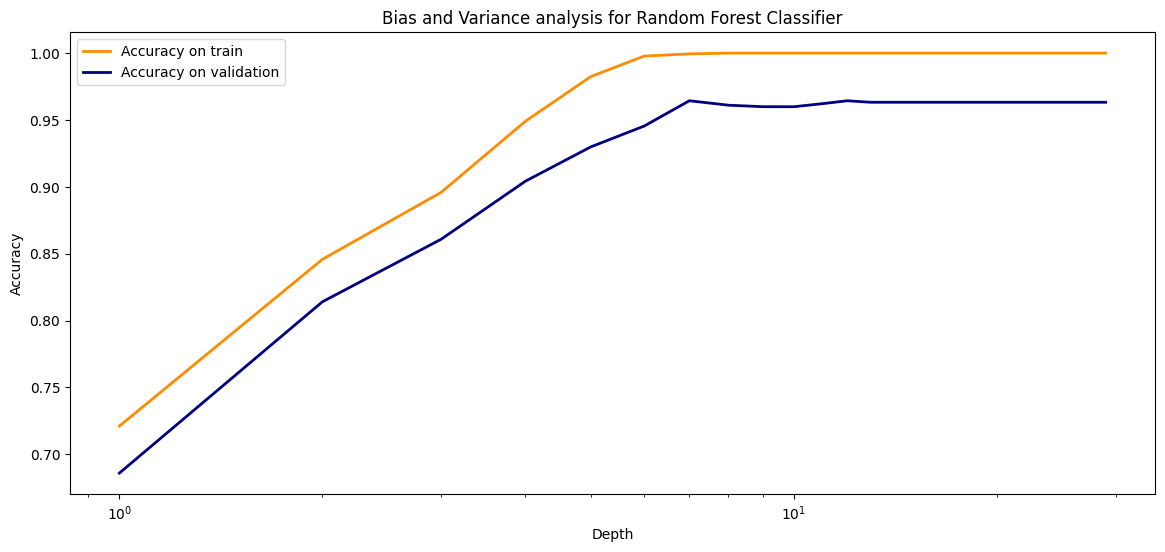

In [31]:
plt.figure(figsize=(14, 6))

xs = max_depth
plt.semilogx(xs, accs_train, label="Accuracy on train",
                color="darkorange", lw=2)
plt.semilogx(xs, accs_val, label="Accuracy on validation",
                color="navy", lw=2)

plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title(f"Bias and Variance analysis for Random Forest Classifier")
plt.legend()

plt.show()

In [33]:
best_val_idx = np.argmax( accs_val )

print("Accuracy on validation:", accs_val[best_val_idx], ", Best depth", max_depth[best_val_idx])

Accuracy on validation: 0.9643823711980136 , Best depth 7


In [34]:
# Best depth = 7, for criterion = "entropy"

# Training the best model on the full train dataset
X_full_train, y_full_train = prepare_data(full_train_df)
X_test, y_test = prepare_data(test_df)


model = RandomForestClassifier( max_depth=7, 
                                criterion="entropy",
                                random_state=41).fit(X_full_train, y_full_train)

# Evaluating the model on the test dataset
y_test_pred = predict(X_test, model)

print(classification_report(y_test, y_test_pred))

# The RFC performs worst on the classes 7, 8 and 9 compared to the SVC model

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        93
           1       0.99      1.00      0.99        91
           2       0.99      1.00      0.99        88
           3       0.99      0.98      0.98        89
           4       0.96      0.99      0.97        98
           5       0.98      0.99      0.98        96
           6       0.99      0.97      0.98        88
           7       0.99      0.93      0.96        86
           8       0.93      0.95      0.94        85
           9       0.94      0.94      0.94        85

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



In [40]:
from sklearn.linear_model import LogisticRegression


n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

penalties = np.logspace(-6, 10, 20)

accs_train, accs_val = [], []
for C in penalties:
    
    scores_train = []
    scores_val = []

    for train_idx, val_idx in tqdm(kfold.split(full_train_df)):
        
        # Prepare the training and validation data
        train_df = full_train_df.iloc[train_idx]
        val_df = full_train_df.iloc[val_idx]

        scaler = MinMaxScaler()
        train_df.loc[:, range(0, 64)] = scaler.fit_transform(train_df.loc[:, range(0, 64)])
        val_df.loc[:, range(0, 64)] = scaler.transform(val_df.loc[:, range(0, 64)])
        
        xtrain, ytrain = prepare_data(train_df)
        xval, yval = prepare_data(val_df)

        # Train the model
        model = LogisticRegression(penalty="l2", 
                                   C=C,
                                   max_iter=300,
                                   random_state=41)
        model.fit(xtrain, ytrain)

        # Make predictions
        y_train_pred = predict(xtrain, model)
        y_val_pred = predict(xval, model)
        
        acc_train = accuracy_score(ytrain, y_train_pred)
        acc_val = accuracy_score(yval, y_val_pred)
        
        scores_train.append(acc_train)
        scores_val.append(acc_val)

    accs_train.append(np.mean(scores_train))
    accs_val.append(np.mean(scores_val))    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

0it [00:00, ?it/s]

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

0it [00:00, ?it/s]

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

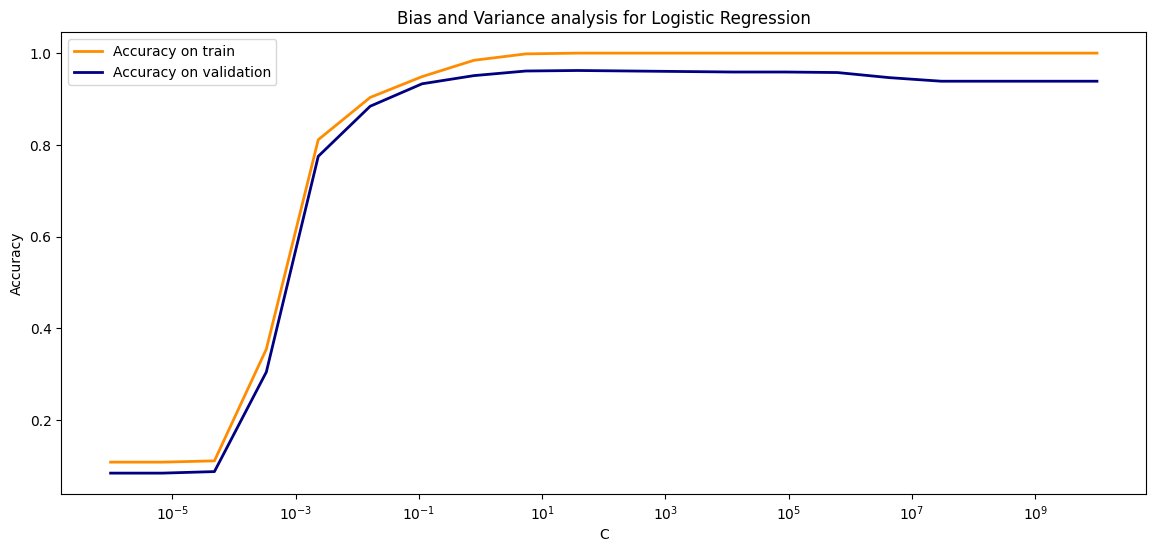

Accuracy on validation: 0.9621415270018622 , Best C 37.92690190732246


In [41]:
plt.figure(figsize=(14, 6))

xs = penalties
plt.semilogx(xs, accs_train, label="Accuracy on train",
                color="darkorange", lw=2)
plt.semilogx(xs, accs_val, label="Accuracy on validation",
                color="navy", lw=2)

plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title(f"Bias and Variance analysis for Logistic Regression")
plt.legend()

plt.show()

best_val_idx = np.argmax( accs_val )
print("Accuracy on validation:", accs_val[best_val_idx], ", Best C", penalties[best_val_idx])

In [42]:
# Best C = 37.92690190732246, for penalty = "l2"

# Training the best model on the full train dataset
norm_full_train_df = full_train_df.copy()
norm_test_df = test_df.copy()

scaler = MinMaxScaler()
norm_full_train_df.loc[:, range(0, 64)] = scaler.fit_transform(norm_full_train_df.loc[:, range(0, 64)])
norm_test_df.loc[:, range(0, 64)] = scaler.transform(norm_test_df.loc[:, range(0, 64)])

X_norm_full_train, y_full_train = prepare_data(norm_full_train_df)
X_norm_test, y_norm_test = prepare_data(norm_test_df)


model = LogisticRegression( penalty="l2", 
                            C=37.92690190732246,
                            max_iter=300,
                            random_state=41).fit(X_norm_full_train, y_full_train)

# Evaluating the model on the test dataset
y_test_pred = predict(X_norm_test, model)

print(classification_report(y_norm_test, y_test_pred))

# The LogReg performs worst on the classes 5, 7, 8 and 9 compared to the SVC model

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        93
           1       0.90      0.99      0.94        91
           2       0.98      1.00      0.99        88
           3       0.95      0.93      0.94        89
           4       0.94      0.98      0.96        98
           5       0.91      0.94      0.92        96
           6       0.99      0.94      0.97        88
           7       0.97      0.90      0.93        86
           8       0.91      0.95      0.93        85
           9       0.97      0.89      0.93        85

    accuracy                           0.95       899
   macro avg       0.95      0.95      0.95       899
weighted avg       0.95      0.95      0.95       899



/home/coderleo/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Pergunta (1pt):** qual classificador apresentou os melhores resultados? Qual critério você utilizou para definir sua escolha? Discuta.

In [43]:
# O modelo que apresentou os melhores resultados foi o SVC:
# svm.SVC(kernel="poly", C=4.641588833612782). 

# Realizamos uma análise sobre as curvas de viés e variância para os modelos SVC, Random Forest e
# Regressão Logística de modo que fosse possível escolhermos o melhor valor para o respectivo
# hiperparâmetro avaliado. Feito isso, treinamos cada modelo "tunado" sobre todo o conjunto de
# treinamento disponível e avaliamos sobre o conjunto de teste 
# (sempre tomando o cuidado de somente aplicarmos a função "transform" sobre os dados 
# de teste e nunca o "fit").

# Após isso, notamos que o modelo que melhor performou sobre os dados de teste foi o SVC, 
# dado que ele apresentou valores melhores de acurácia, precisão, revocação e F1 sobre todas as classes
# quando comparado com os outros dois modelos.


norm_full_train_df = full_train_df.copy()
norm_test_df = test_df.copy()

scaler = MinMaxScaler()
norm_full_train_df.loc[:, range(0, 64)] = scaler.fit_transform(norm_full_train_df.loc[:, range(0, 64)])
norm_test_df.loc[:, range(0, 64)] = scaler.transform(norm_test_df.loc[:, range(0, 64)])

X_norm_full_train, y_full_train = prepare_data(norm_full_train_df)
X_norm_test, y_norm_test = prepare_data(norm_test_df)


model = svm.SVC(kernel="poly", C=4.641588833612782).fit(X_norm_full_train, y_full_train)

# Evaluating the model on the test dataset
y_test_pred = predict(X_norm_test, model)

print( classification_report(y_norm_test, y_test_pred) )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.97      0.99      0.98        91
           2       0.98      1.00      0.99        88
           3       0.98      0.98      0.98        89
           4       0.99      0.99      0.99        98
           5       0.98      0.99      0.98        96
           6       1.00      0.98      0.99        88
           7       0.99      0.97      0.98        86
           8       0.96      0.96      0.96        85
           9       0.99      0.98      0.98        85

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899

